## Hierarhično gručenje

Na predavanjih smo spoznali algoritem <b>hieraričnega gručenja</b>. Njegova glavna značilnost je, da omogoča primerjavo objektov zgolj na podlagi poznavanja <i> mere razdalje </i> med njimi. Predstavitev podatkov torej ni nujno omejena na vektorske prostore.

Algoritem je determinističen in ne predpostavlja števila gruč. Rezultat gručenja bo izračunan naenkrat za vsa možna števila gruč v intervalu $[1, n]$, odločitev o številu pa bo sprejeta po izračunu.



<font color="blue"><b>Razmisli.</b></font> Kakšna je časovna zahtevnost algoritma za hierarhično gručenje? Kako se primerja z metodo K-means?

In [1]:
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('PR.mplstyle')

import Orange
import scipy.cluster.hierarchy as sch
import scipy

### Podatki

<img src="slike/živali.jpg"></img> 

Današnji podatki spominjajo na (starejši generaciji dobro znani) album sličic z živalmi. Vsebuje 59 živalskih vrst ter 16 atributov, ki opisuje pripadajoče anatomske značilnosti. Živali so razdeljene v 7 razredov.

In [2]:
data = Orange.data.Table('podatki/zoo.tab')
print(data.domain)
print(data[:2])

print(np.linalg.norm(data.X[0]-data.X[1]))
print(np.linalg.norm(data.X[0]-data.X[1], ord=1))

[hair, feathers, eggs, milk, airborne, aquatic, predator, toothed, backbone, breathes, venomous, fins, legs, tail, domestic, catsize | type] {name}
[[1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 4, 0, 0, 1 | mammal] {aardvark},
 [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 4, 1, 0, 1 | mammal] {antelope}]
1.41421356237
2.0


Zanimala nas bo predvsem matrika `X`, ki podatke hrani v številski obliki.

In [3]:
X = data.X
Y = data.Y
print(X.shape)
print(X)

(59, 16)
[[ 1.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.  2.  0.  0.  1.]
 [ 1.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  2.  1.  0.  1.]
 [ 0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.  1.  0.  1.  0.  0.]
 [ 1.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.  2.  1.  0.  1.]
 [ 1.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  2.  1.  1.  1.]
 [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  0.  1.  0.  1.  1.  0.]
 [ 1.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  2.  0.  1.  0.]
 [ 0.  1.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.  1.  1.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  2.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  4.  0.  0.  0.]
 [ 0.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.  1.  0.  1.  0.  1.]
 [ 0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.]
 [ 0.  1.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.

Rezultat gručenja dobimo z uporabo modula `scipy.cluster.hierarchy` in metode `linkage`. Slednja izračune povezave v drevesu (dendrogramu) glede na dano mero razdalje (`metric`) in načinom merjenja razdalj med gručami (`method`).

In [4]:
L = sch.linkage(X, method="average", metric="cityblock")

Z uporabo funkcije `dendrogram` narišemo drevo in mu priredimo oznake. Funkcija deluje v navezi z že znano knjižnico `matplotlib`.

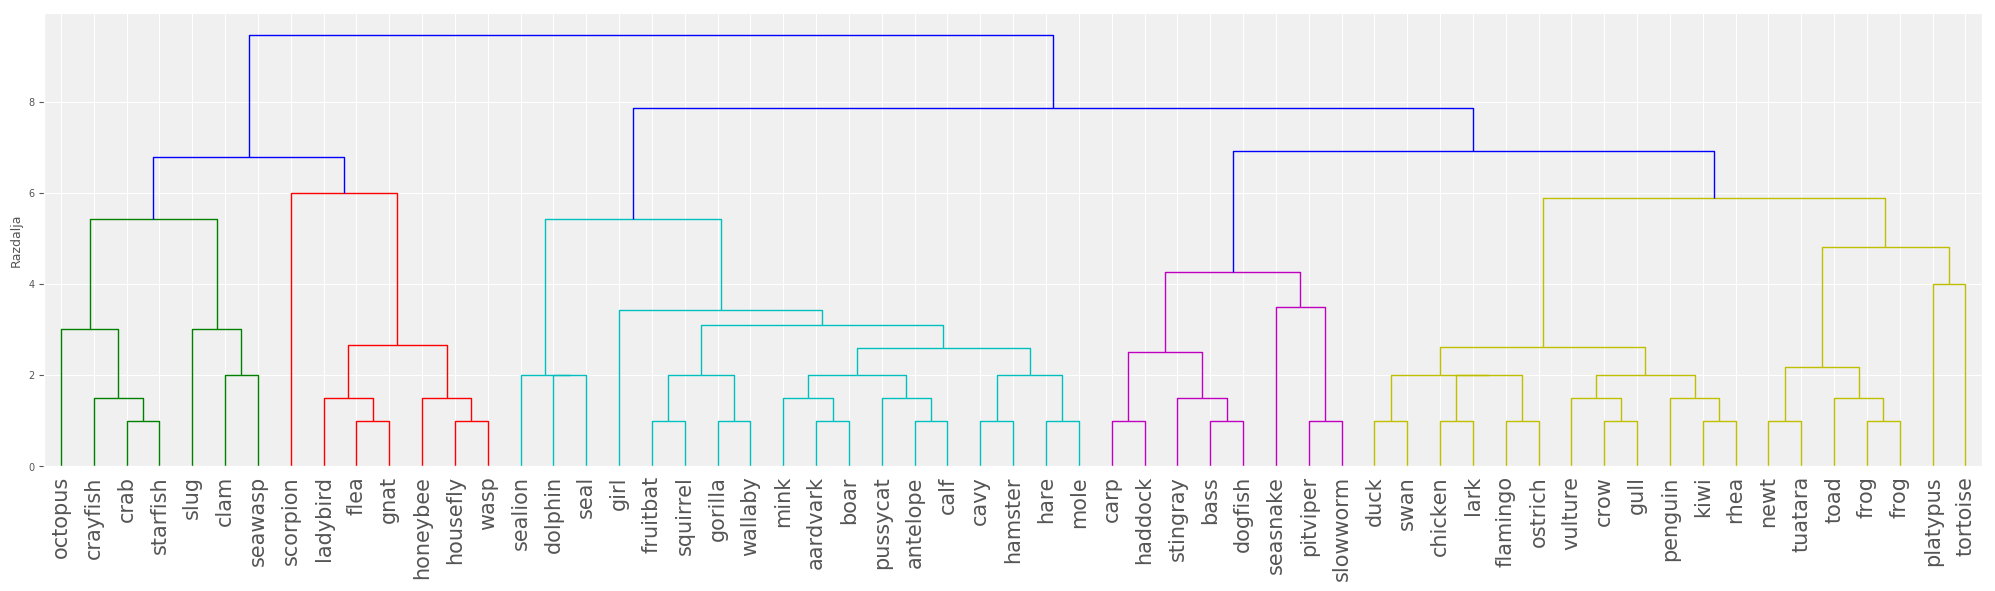

In [5]:
plt.figure(figsize=(25, 6))
labels = [row["name"].value for row in data]
D      = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Razdalja")
plt.show()

V redu, za prvi poizkus. Vseeno izgleda dendrogram nekoliko sploščen. Preveri, kako na graf vplivajo različne ...

### Metode povezovanja

Metode povezovanja določajo način, kako izračunati razdaljo med dvema poljubno velikima gručama točk.
* <b>Posamično povezovanje</b> (method="single"); Razdalja med gručama je razdalja med najbližjima točkama gruč.
* <b>Povprečna razdalja</b> (method="average"); Povprečna razdalja med vsemi pari točk. 
* <b>Razdalja med središčema</b> (method="centroid"); Izračuna središči gruč v prostoru ter njuno medsebojno razdaljo. Mera razdalje je nujno evklidska.

<font color="green"><b>Naredi sam/a.</b></font> Preizkusi različne oblike dendrograma glede na izbrano mero razdalje.

In [6]:
# Preizkusi različne načine merjenja razdalje med gručami
L = sch.linkage(X, method="single",)

Ali je evklidska razdalja res najbolj primeren način primerjanja atributov, ki so diskretni? Ne vedno.

### Mere razdalje

Način določanja interpretacije razdalje med točkama $\vec{x} = (x_1, x_2, ..., x_p)$ in $\vec{y} = (y_1, y_2, ..., y_p)$ vpliva na rezultat hierarhičnega gručenja. Izbira ustrezne mere je odvisna od narave podatkov in čimbolje odgovarja na vprašanje: <i>kaj pomeni, da sta dva primera podobna?</i>

Na izbiro ustrezne mere lahko vplivajo:
* Prisotnost manjkajočih vrednosti
* Predstavitev podatkov (vektorji, nizi znakov, slike, ...)
* Tip atributov in interpretacija vrednosti


Nekaj pogostih mer razdalje:
* Evklidska razdalja <code>(metric="euclidean")</code>

$$ d(\vec{x}, \vec{y}) = \sqrt{(x_1-y_1)^2 + (x_2 - y_2)^2 + ... + (x_p - y_p)^2} $$

* Manhattanska razdalja <code>(metric="cityblock")</code>

$$ d(\vec{x}, \vec{y}) = |x_1-y_1| + |x_2 - y_2| + ... + |x_p - y_p| $$

* Kosinusna razdalja <code>(metric="cosine")</code>

<p>Predstavlja <i>kosinus kota</i> med vektorjema $\vec{x}$ in $\vec{y}$ - manjši kot pomeni večjo podobnost. Uporabna za primerjavo podobnosti med vektorji, neupoštevajoč absolutnih velikosti.</p>

$$ d(\vec{x}, \vec{y}) = 1 - \frac{\vec{x} \cdot \vec{y}}{\|\vec{x}\| \|\vec{y}\|} $$

* Jaccardov index <code>(metric="jaccard")</code>

<p>Izmeri delež ujemanj med pari soležnih komponent $(x_i, y_i)$, kjer je vsaj ena izmed vrednosti $x_i$ ali $y_i$ večja od nič. Primerna za uporabo v primerih, ko imamo opravka z manjkajočimi vrednostmi ali diskretnimi atributi.</p>

Popoln spisek razdalj najdeš v <a href="http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.spatial.distance.pdist.html">dokumentaciji</a>.

<br/>
<font color="blue"><b>Razmisli.</b></font> Poizkusi se spomniti vrste podatkov, kjer bi bilo smiselno uporabiti vsako posamezno mero.

### Določanje števila gruč

Koliko gruč je v podatkih? Na to vprašanje je težko odgovoriti in tudi sicer velja za odprto vprašanje na področju storjnega učenja. Vseeno poznamo nekaj kazalcev, ki jih v grobem delimo na 
* <font color="green">nadzorovane</font> (znani so resnični razredi podatkov)
* <font color="blue">nenadzorovane</font> (znane so samo značilke in/ali razdalje med primeri)

Za določitev pripadnosti primerov gručam uporabimo funkcijo `fcluster`. Slednja prejme parameter `t`, ki določa razdaljo pri kateri <i>odsekamo</i> dendrogram, t.j. odstranimo vse povezave, ki so daljše od dane dolžine. Preostale povezane komponente grafa dendrograma tako tvorijo skupine.

In [7]:
L = sch.linkage(X, method="average", metric="cityblock")   
t = 3.5
predictions = sch.fcluster(L, t=t, criterion="distance").ravel()
classes     = data.Y.ravel()   # resnicni razredi 

print("Primer", "Resnični razred", "Gruča")
for row, category, prediction in list(zip(data, classes, predictions ))[2:10]:
        print("%s\t%d\t%d" % (row["name"], category, prediction))

Primer Resnični razred Gruča
bass	2	7
boar	5	6
calf	5	6
carp	2	7
cavy	5	6
chicken	1	9
clam	4	2
crab	4	1


Ponovno narišemo dendrogram in ga <i>odsekamo</i> pri dani razdalji. V nadaljevanju si bomo ogledali številske ocene uspešnosti gručenja.

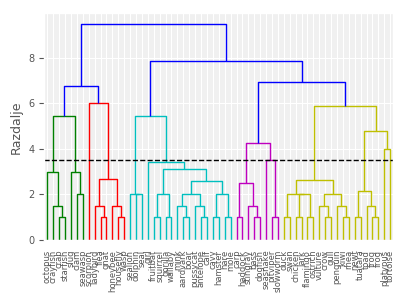

In [8]:
D = sch.dendrogram(L, labels=labels)
plt.plot([0, 1000], [t, t], "k--")
plt.ylabel("Razdalje")
plt.show()

#### Skupna deljena informacija

Mera skupne deljene informacije je uporabna, ko so na voljo informacije o resničnih razredih, v katere spadajo primeri. Pri tem ni odveč poudariti, da resnični razredi ne smejo biti uporabljeni pri deljenju primerov v skupine.

Naključne dodelitve oznak gruč imajo vrednost skupne deljene informacije 
blizu `0.0` za vsako vrednost števila skupin in števila primerov. Popolno ujemanje gruč z obstoječimi razredi ima vrednost `1`.
Mera ni odvisna od predstavitve podatkov, t.j. ni potrebno da so podatki v vektorskem prostoru, saj je odvisna samo od oznak.

In [9]:
from sklearn.metrics import adjusted_mutual_info_score
score = adjusted_mutual_info_score(classes, predictions)
score

0.74442901297970121

#### Koeficitent silhuete

Koeficient silhuete je nenadzorovana meta v območju med `-1` (napačno dodeljene skupine) in `1` (zelo goste, dobro ločene skupine). Večja notranja gostota znotraj skupin in večja razdalja sta premosorazmeni s koeficientom. Tudi ta mera ne predpostavlja, da so podatki v vektorskem prostoru, je pa odvisna od izbrane mere razdalje.

<font color="green"><b>Naredi sam/a.</b></font> Preveri, kako se ocena spreminja glede na izbrano mero razdalje. Katera mera razdalje najbolje oceni gručenje? Ali je rezultat smiseln?

In [10]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, predictions, metric="cityblock")
score

0.43513460144066435

<font color="green"><b>Naredi sam/a.</b></font> Izvedi analizo gručenja na podatkih o živalih  tako, da izbereš ustrezno metodo povezovanja, mero razdalje in število gruč. Uporabi eno od predstavljenih mer podobnosti ter poišči tako kombinacijo omenjenih nastavitev, da bo rezultat gručenja karseda visok.

In [11]:
# ...